<a href="https://colab.research.google.com/github/17jmumford/ropewiki-scraper/blob/main/RopeWikiScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RopeWiki Scraper

## Description

This is a scraper designed to regularly export data from the open source website RopeWiki, a canyoneering database. This data will be integrated into the Canyoneer app on the Apple Store.

## Using this Scraper

This scraper is currently under construction, but you can use the first parts. Run the imports, pull the base csv and clean, then use the export cell that manually exports the data.

## To do
1. Finish KML data extraction and conversion
2. Split longitude and latitude into separate attributes
3. Convert month field into an array
4. Check what is happening with num of rappels
5. Determine how to integrate with Canyoneer
 * Lambda that puts data into public S3 bucket?

MediaWiki API Documentation
https://www.mediawiki.org/wiki/API:Main_page


## Imports

In [ ]:
!sudo apt-get install gdal-bin libgdal-dev
!pip install pykml
!pip install geopandas lxml

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.4.3+dfsg-1~jammy0).
libgdal-dev is already the newest version (3.4.3+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
import geopandas as gpd
from google.colab import files
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd
from pykml import parser
import re
import requests
import seaborn as sns
from lxml import etree
from lxml import objectify
import json

## Pull base csv and clean

In [ ]:
base_url = "https://ropewiki.com/index.php?title=Special:Ask&x=-5B-5BCategory%3ACanyons-5D-5D-5B-5BCategory%3ACanyons-5D-5D-5B-5BLocated-20in-20region.Located-20in-20regions%3A%3AX-7C-7C{}-5D-5D%2F-3FHas-20pageid%3DPAGEID%2F-3FHas-20name%3DLocation%2F-3FHas-20coordinates%3DCoords%2F-3FLocated-20in-20region%3DRegion%2F-3FHas-20user-20rating%3DQuality%2F-3FHas-20rating%3DRating%2F-3FHas-20time-20rating%3DTime-20Rating%2F-3FHas-20technical-20rating%3DTechnical-20Rating%2F-3FHas-20water-20rating%3DWater-20Rating%2F-3FHas-20extra-20risk-20rating%3DRisk-20Rating%2F-3FHas-20fastest-20typical-20time%3DMin-20Time%2F-3FHas-20slowest-20typical-20time%3DMax-20Time%2F-3FHas-20length-20of-20hike%3DHike%2F-3FRequires-20permits%3DPermits%2F-3FHas-20number-20of-20rappels%3DRappels%2F-3FHas-20url%3DURL%2F-3FHas-20longest-20rappel%3DLongest%2F-3FHas-20best-20month%3DBest-20Months%2F-3FHas-20shuttle-20length%3DShuttle%2F-3FHas-20vehicle-20type%3DVehicle&format=csv&limit=2000&sort=Has_rank_rating%2C%20Has_name&order=descending%2C%20ascending&mainlabel=-&offset=0"
# Note: this method of iterating through regions is janky. Unfortunately the offset does not seem to work, so this is the best for now...

regions = ['Asia','Central America','Albania','Austria','Bavaria','Friuli Venezia Giulia','Lombardia','Piemonte',"Provence-Alpes-Cote d'Azur",'Slovenia','Switzerland','Trentino-Alto Adige',"Valle d'Aosta",'Andorra','Bulgaria','Croatia','France','Germany','Greece','Hungary','Iceland','Ireland','Islas Canarias','Italy','Lithuania','Macedonia','Montenegro','Poland','Portugal','Romania','Slovakia','Spain','Turkey','United Kingdom','Middle East','North America','Canada','Mexico','Northeast','Pacific Northwest','Alaska','Arizona','Arkansas','California','Central Utah','Colorado','Connecticut','Georgia','Hawaii','Idaho','Maine','Massachusetts','Montana','Nevada','New Mexico','New York','North Carolina','Oregon','South Carolina','South Dakota','Texas','Utah','Virginia','Washington','West Desert','Wyoming','Pacific','South America','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Peru','Playa Montezuma','Venezuela']
everything_df = pd.DataFrame()

for region in regions:
    # Format the URL with the current offset
    url = base_url.format(region)

    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # If successful, get the text representation of the CSV
        csv_data = response.text
        data = pd.read_csv(StringIO(csv_data))

        everything_df = pd.concat([everything_df, data])
        print(region, end=" ")
    else:
        print("Failed to download CSV")
        break

Asia Central America Albania Austria Bavaria Friuli Venezia Giulia Lombardia Piemonte Provence-Alpes-Cote d'Azur Slovenia Switzerland Trentino-Alto Adige Valle d'Aosta Andorra Bulgaria Croatia France Germany Greece Hungary Iceland Ireland Islas Canarias Italy Lithuania Macedonia Montenegro Poland Portugal Romania Slovakia Spain Turkey United Kingdom Middle East North America Canada Mexico Northeast Pacific Northwest Alaska Arizona Arkansas California Central Utah Colorado Connecticut Georgia Hawaii Idaho Maine Massachusetts Montana Nevada New Mexico New York North Carolina Oregon South Carolina South Dakota Texas Utah Virginia Washington West Desert Wyoming Pacific South America Argentina Bolivia Brazil Chile Colombia Ecuador Peru Playa Montezuma Venezuela 

In [ ]:
canyons_df = everything_df.copy(deep=True)
# remove non canyon pages. Drops it down to about 11,000 pages.
for remove in ['cav', 'POI', 'Via', 'Pit', 'Mine']:
  canyons_df = canyons_df[~canyons_df['Rating'].str.contains(remove, case=False, na=False)]
# remove 'ft' so it's just a number on Longest
canyons_df['Longest'] = pd.to_numeric(canyons_df['Longest'].str.replace(' ft', '').str.replace(',', ''), errors='coerce')
# drop canyons with null ratings and duplicates. Reduces count to about 6,700ish.
canyons_df_no_null_ratings = canyons_df.dropna(subset=['Rating'])
df_clean = canyons_df_no_null_ratings.drop_duplicates()
df_export = df_clean.drop(columns=['Rating'])

## Pull HTML



In [ ]:

df_test = df_export.copy(deep=True)
# Add an empty 'HTMLDescription' column to df_export
df_test['HTMLDescription'] = [None] * len(df_test)

# Number of IDs to query at a time
chunk_size = 100

# Base URL for the request
base_url = 'http://ropewiki.com/api.php?action=query&export=true&pageids='

# Regex pattern to match everything between '==Introduction==' and '==Background==', inclusive
pattern = re.compile(r'==Introduction==.*?==Background==', re.DOTALL)

# Iterate through the PAGEIDs in chunks of 100
for i in range(0, len(df_test), chunk_size):
    # Get the current chunk of 100 PAGEIDs
    pageids_chunk = df_test['PAGEID'][i:i + chunk_size]
    print(". ", end="")
    # Concatenate the PAGEIDs with the '|' delimiter
    pageids_str = ' | '.join(map(str, pageids_chunk))

    # Construct the full URL
    url = base_url + pageids_str

    # Make the request
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Use the regex pattern to find the required text
        matches = pattern.findall(response.text)

        # Store the extracted text in the dataframe
        for j, match in enumerate(matches):
            df_test.loc[i + j, 'HTMLDescription'] = match
    else:
        print(f"Request failed with status code {response.status_code}")

  PAGEID               Location                            Coords  \
0  18287           Syange Khola  28.385833333333, 84.400555555556   
1  18285  Sansapu Khola (Lower)                     28.365, 84.41   
2  18286           Raindu Khola  28.375555555556, 84.393333333333   
3  18284            Gopte Khola  28.346388888889, 84.399166666667   
4  18283         Kabindra Khola  28.330277777778, 84.397777777778   

              Region  Quality Time Rating  Technical Rating Water Rating  \
0  Mid-Western Nepal      4.2         III               4.0           C1   
1  Mid-Western Nepal      3.9          II               4.0            B   
2  Mid-Western Nepal      3.9         III               4.0            B   
3  Mid-Western Nepal      3.2          II               4.0            A   
4  Mid-Western Nepal      2.9          II               3.0            B   

  Risk Rating   Min Time Max Time Hike Permits  Rappels  \
0           R       6 hr     7 hr  NaN      No      NaN   
1         

## Download KML Data

In [ ]:
# Define the path to your KML file
response = requests.get('https://ropewiki.com/luca/rwr?gpx=off&kml=http://ropewiki.com/index.php/KMLList?limit=100&action=raw&templates=expand&ctype=application/x-zope-edit&num=on&numname=on&group=link&query=%5B%5BCategory%3ACanyons%5D%5D%5B%5BLocated%20in%20region.Located%20in%20regions%3A%3AX%7C%7CWorld%5D%5D&sort=Has_rank_rating%2C%20Has_name&order=descending%2C%20ascending&gpx=off&mapnum=&mapname=&mapdata=&maploc=&maplinks=&allmap=&qname=World&filename=World&ext=.kml')


In [ ]:

if response.status_code == 200:
  kml_file = BytesIO(response.content)
  kml_content = parser.parse(kml_file).getroot()
else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
# children = kml_content.Document.getchildren()
# print(children[1].name)
print(response.content)

b'<?xml version="1.0" encoding="UTF-8"?>\n<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:gpxx="http://www.garmin.com/xmlschemas/GpxExtensions/v3">\n<Document>\n<Folder>\n<name>Ropewiki Map Export</name>\n<description>http://www.ropewiki.com</description>\n<Style id="000">\n<IconStyle><scale>1.0</scale><Icon><href>https://ropewiki.com/images/7/75/Starn00.png</href></Icon></IconStyle>\n<LabelStyle><color>ffc0c0ff</color><scale>0.0</scale></LabelStyle>\n</Style><Style id="001">\n<IconStyle><scale>1.0</scale><Icon><href>https://ropewiki.com/images/7/75/Starn00.png</href></Icon></IconStyle>\n<LabelStyle><color>ffc0c0ff</color><scale>1.1</scale></LabelStyle>\n</Style><StyleMap id="00"><Pair><key>normal</key><styleUrl>#000</styleUrl></Pair><Pair><key>highlight</key><styleUrl>#001</styleUrl></Pair></StyleMap><S

In [ ]:
kml_files = []
i = 0
# Iterate through the folders containing the tracks
for child in kml_content.Document.getchildren():
    kml_file = etree.tostring(child, pretty_print=True).decode()
    title = child.name
    kml_files.append({'Title': title, 'File': kml_file})
kml_files.pop(0)
kml_files_df = pd.DataFrame(kml_files)

In [ ]:
kml_files_df.to_csv('kml_data_test_2.csv', index=False)
files.download('kml_data_test_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convert KML (TODO)

In [ ]:
import fiona

print(fiona.supported_drivers)

{'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r'}


In [ ]:
# Read the KML file
geojson_files = []
fiona.drvsupport.supported_drivers['KML'] = 'rw'
# Loop over your list of KML files
for kml_info in kml_files:
    title = kml_info['Title']
    kml_data = kml_info['File'].replace("Folder", "kml", 1)
    kml_data = '<?xml version="1.0" encoding="UTF-8"?>\n' + '</kml>'.join(kml_data.rsplit('</Folder>', 1))
    print("title: ", title)
    with open(f"{title}.kml", "w") as temp_file:
        temp_file.write(kml_data)
    try:
      gdf = gpd.read_file(f"{title}.kml")
      geojson_obj = json.loads(gdf.to_json())
      geojson_files.append({'Title': title, 'GeoJSON': geojson_obj})
    except Exception as e:
      print("Exception for ", title, ": ")



geojson_df = pd.DataFrame(geojson_files)

title:  Jump Trip (Lower)
title:  Matacanes
title:  Deer Creek (Grand Canyon)
title:  Rio La Venta Expedition
title:  High Falls
title:  Heaps Canyon
title:  Imlay Canyon (Sneak Route)
title:  Lodrino (Lower)
title:  Gorg Blau i Sa Fosca
title:  Big Creek (South Cascades)
title:  The Squeeze
title:  Choprock Canyon (South Fork)
title:  Stevenson Creek (Lower)
title:  Waterholes Canyon (Lower)
title:  Box Canyon (British Columbia)
title:  Gamchi
title:  Poe Canyon
title:  Chorreadero
title:  Chipitin
title:  Mordor Canyon
title:  Claustral
title:  Segnes
title:  Gorgopotamos
title:  North Fork Kaweah River (Lower)
title:  Davis Creek Canyon
title:  Illusions Canyon
title:  Oules de Freissinieres
title:  Kolob Canyon


ERROR:fiona._env:Pointer 'hLayer' is NULL in 'OGR_L_GetName'.



title:  Pandora's Box
title:  Eagle Creek
title:  West Clear Creek (Hanging Gardens)
Exception for  West Clear Creek (Hanging Gardens) : 
title:  Corbett Creek
title:  South Branch Feather River (Log Ride)
title:  Trou de Fer (Bras Mazerin)
title:  Havasu Canyon
title:  Monmouth Canyon
title:  Trou de Fer (Bras Caverne)
title:  Ladder Creek
title:  Wilsons Creek
title:  Cueva del Rio La Venta
title:  Fish Fork
title:  Maglia
title:  Ice Cube Canyon (The Maze)
title:  Imlay Canyon (Full)
title:  Hager Canyon
title:  Bares
title:  Paria Canyon
title:  Shenanigans
title:  Donini
title:  Takamaka 1
title:  Turnigla
title:  Gouffre d'Enfer
title:  Gries
title:  Ore Stream
title:  Cascade Creek
title:  Gata Fiera
title:  Bodengo 2
title:  Trummelbach
title:  Trummelbach III
title:  Viellia
title:  Cañon del Infiernillo
title:  North Fork Kaweah River (Upper)
title:  Saufla (Lower)
title:  Sefi
title:  Bras Magasin
title:  Deadhorse Creek


ERROR:fiona._env:Pointer 'hLayer' is NULL in 'OGR_L_GetName'.



title:  Aravaipa Canyon
Exception for  Aravaipa Canyon : 
title:  Llech
title:  Pine Creek Canyon
title:  Pontirone (Lower)
title:  Isorno (Final)
title:  Osogna (Lower)
title:  Buckskin Gulch
title:  Frye Creek Canyon (S'mores)
title:  Iragna (Middle)
title:  Marble Fork Kaweah River (Chrysalis)
title:  Parkett Creek
title:  Yosemite Falls (Middle Earth)
title:  Male Vesse (Upper)
title:  Cormor
title:  Meije (Lower)
title:  Thornton Creek
title:  Bitet (Lower)
title:  Canyon Creek (Opho)
title:  Claretto (Upper)
title:  Mathers Creek
title:  Soffia (Lower)
title:  Styx Canyon (North Fork)
title:  Bear Creek Canyon
title:  Rosenlaui (Lower)
title:  Arvi
title:  Pinon Canyon
title:  Ruta Vertigo Via Ferrata
title:  Flem
title:  Mordor Medio
title:  Heart of Stone Canyon
title:  Hidden Canyon (North Cascades)
title:  Coyote Buttes (The Wave)


## Download options

In [ ]:
# download geojson data
geojson_df.to_csv('geojson_data.csv', index=False)
files.download('geojson_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# download without HTML
df_export.to_csv('ropewiki_canyons_with_url.csv', index=False)
files.download('ropewiki_canyons_with_url.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download as JSON
json_data = df_export.to_dict(orient='records')
with open('ropewiki.json', 'w') as file:
    json.dump(json_data, file, indent=2)
files.download('ropewiki.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download as JSON
json_data = df_test.to_dict(orient='records')
with open('ropewiki.json', 'w') as file:
    json.dump(json_data, file, indent=2)
files.download('ropewiki.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# download KML data
kml_files_df.to_csv('kml_data.csv', index=False)
files.download('kml_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## EDA

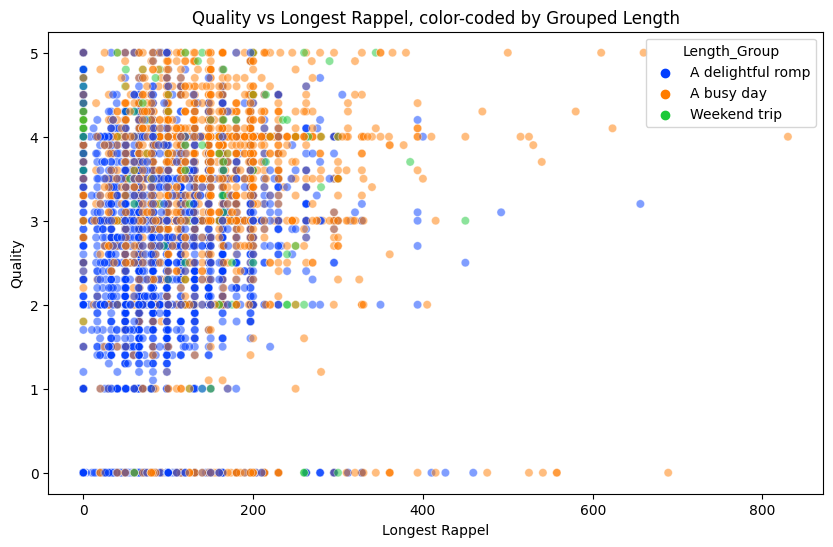

In [ ]:
group_mapping = {'I': 1, 'II': 1, 'III': 2, 'IV': 2, 'V': 3, 'VI': 3}
df_updated = df_export
# Apply the mapping to the 'Length' column to create the 'Length_Group' column
df_updated['Length_Group'] = df_updated['Length'].map(group_mapping)

# Create a scatterplot with dots
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Longest', y='Quality', hue='Length_Group', palette='bright', alpha=.5, data=df_updated)

# Set plot title and labels
plt.title('Quality vs Longest Rappel, color-coded by Grouped Length')
plt.xlabel('Longest Rappel')
plt.ylabel('Quality')

# Get the current legend
legend = scatter.legend_

# Update the legend texts

legend.texts[0].set_text('A delightful romp')
legend.texts[1].set_text('A busy day')
legend.texts[2].set_text('Weekend trip')

plt.show()


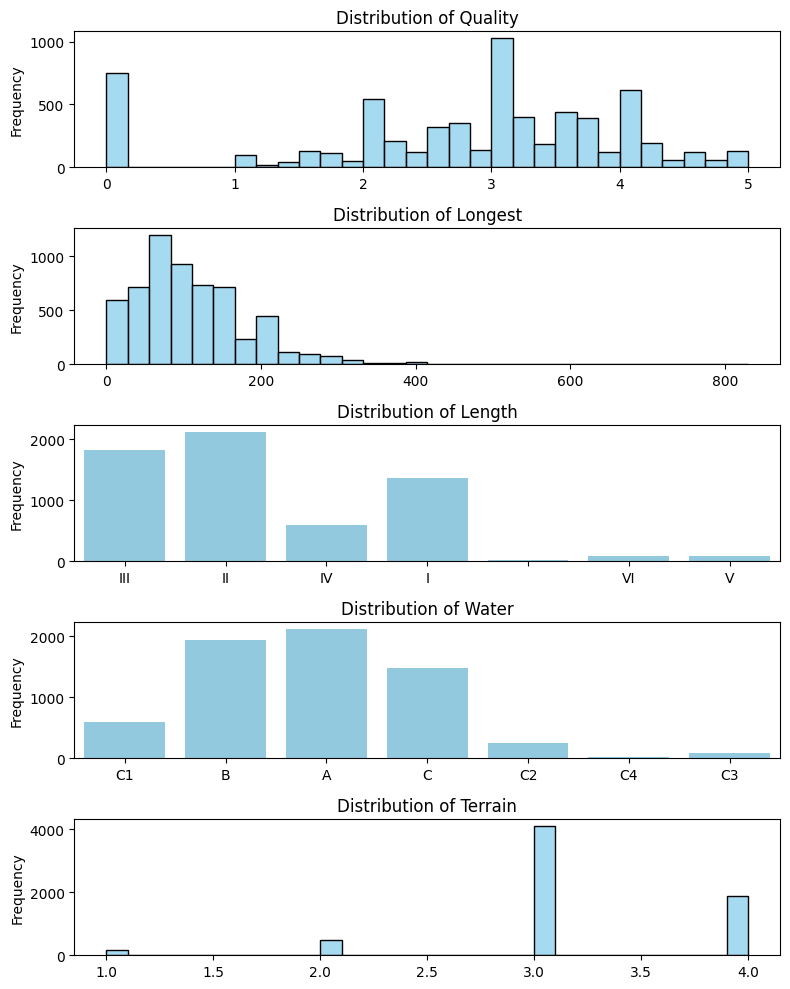

In [ ]:
df_improved = df_export

# Now we'll generate the visualizations for 'Longest', 'Quality', 'Length', 'Terrain', and 'Water'

# Create a list of the attributes we're interested in
attributes_improved = ['Quality', 'Longest', 'Length', 'Water', 'Terrain']

# Set up the matplotlib figure
f, axes = plt.subplots(len(attributes_improved), 1, figsize=(8, 10), sharex=False)

# Generate a histogram/distribution plot for each attribute
for ax, attribute in zip(axes, attributes_improved):
    if df_improved[attribute].dtype in ['int64', 'float64']:
        sns.histplot(df_improved[attribute].dropna(), kde=False, ax=ax, color='skyblue', bins=30)
    else:
        sns.countplot(x=df_improved[attribute].dropna(), ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {attribute}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Useful links
* canyons list: https://ropewiki.com/Category:Canyons
* Export pages as xml: https://ropewiki.com/index.php?title=Special:Export&action=submit
* Browse data?: https://ropewiki.com/Special:BrowseData/Canyons
* Access via PageID: https://ropewiki.com/index.php?curid=<PAGEIDHERE>

### Example json frrom repowiki_database.json

```
  {
    "URL": "http://ropewiki.com/The_Squeeze",
    "Name": "The Squeeze",
    "Quality": 4.75,
    "Popularity": 64,
    "Latitude": 38.5445,
    "Longitude": -110.9509,
    "Months": [
      "April",
      "May",
      "June",
      "July",
      "August",
      "September",
      "October",
      "November",
      "December"
    ],
    "Difficulty": "4b",
    "Vehicle": "4WD - High Clearance",
    "Shuttle": "None",
    "Permits": "No",
    "Sports": [
      "canyoneering"
    ],
    "Time": "IV",
    "RappelCountMin": 16,
    "RappelCountMax": 16,
    "RappelLengthMax": 99,
    "HTMLDescription": "<span class=\"mw-headline\" id=\"Introduction\">Introduction</span>\n\n<span class=\"mw-headline\" id=\"Approach\">Approach</span>\n\n<span class=\"mw-headline\" id=\"Descent\">Descent</span>\n\n<span class=\"mw-headline\" id=\"Exit\">Exit</span>\n\n<span class=\"mw-headline\" id=\"Red_tape\">Red tape</span>\n\n<span class=\"mw-headline\" id=\"Beta_sites\">Beta sites</span>\n\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://roadtripryan.com/go/t/utah/san-rafael-swell/squeezecanyon\">RoadTripRyan.com</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://ropewiki.com/User:Super_Amazing_Map?id=The_Squeeze_-_San_Rafael_Swell\">Super Amazing Map</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://climb-utah.com/SRS/squeeze1.htm\">Climb-Utah.com</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://canyoncollective.com/betabase/the-squeeze-from-the-top-via-miners-trail.63\">CanyonCollective.com</a> &nbsp;: The Squeeze from the top via Miners Trail</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://canyoneeringusa.com/images/stories/PDFs/Swell/MoroniSlopes/LowerSqueeze.pdf\">CanyoneeringUSA.com</a> &nbsp;: Lower Squeeze from Muddy Creek</li>\n\n<span class=\"mw-headline\" id=\"Trip_reports_and_media\">Trip reports and media</span>\n\n<li> <a rel=\"nofollow\" class=\"external text\" href=\"https://www.stavislost.com/hikes/trail/muddy-creek-and-overlook\">The Squeeze 2019-09-28 Stav is Lost</a></li>\n<li> <a rel=\"nofollow\" class=\"external text\" href=\"https://www.youtube.com/watch?v=Yz-8pqVUGiU\">Climb Utah Squeeze Video</a></li>\n<li> <a rel=\"nofollow\" class=\"external free\" href=\"https://www.facebook.com/pat.winstanley.7/media_set?set=a.714460858612614.1073741916.100001461198708&amp;type=3\">https://www.facebook.com/pat.winstanley.7/media_set?set=a.714460858612614.1073741916.100001461198708&amp;type=3</a></li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://candition.com/canyons/the-squeeze\">Candition.com</a> &nbsp;: The Squeeze</li>\n\n<span class=\"mw-headline\" id=\"Background\">Background</span>\n\n\n\n\n\n\n<h2><span class=\"mw-headline\" id=\"Credits\">Credits</span></h2>\n<div id=\"idcredits\" class=\"notranslate\" style=\"display:none\">The Squeeze</div>\n<div>Information provided by <span id=\"Pcredits\">automated processes</span>.  Main photo by <span id=\"Jcredits\">(unknown)</span>. Authors are listed in chronological order. <div id=\"fb-root\"></div><div class=\"fb-like\" data-href=\"http://ropewiki.com/The_Squeeze\" data-layout=\"standard\" data-action=\"like\" data-show-faces=\"true\" data-share=\"true\"></div></div>\n<div id=\"disclaimer\" style=\"font-size:0.75em\"><p>\nIn all habitats live animals and plants that deserve respect, please minimize impact on the environment and observe the local ethics. Canyoneering, Canyoning, Caving and other activities described in this site are inherently dangerous. Reliance on the information contained on this site is solely at your own risk. There is no warranty as to accuracy, timeliness or completeness of the information provided on this site. The site administrators and all the contributing authors expressly disclaim any and all liability for any loss or injury caused, in whole or in part, by its actions, omissions, or negligence in procuring, compiling or providing information through this site, including without limitation, liability with respect to any use of the information contained herein. If you notice any omission or mistakes, please contribute your knowledge (<a href=\"/Contributing\" title=\"Contributing\">more information</a>).</p></div>\n"
  },
```



 https://ropewiki.com/luca/rwr?gpx=off&kml=http://ropewiki.com/index.php/KMLList?limit=100&action=raw&templates=expand&ctype=application/x-zope-edit&num=on&numname=on&noloc=on&group=link&query=%5B%5BCategory%3ACanyons%5D%5D%5B%5BJump_Trip_%28Lower%29%5D%5D&sort=&order=&user=&list=&qname=&ext=.kml